In [1]:
import pandas as pd
import cv2
import numpy as np
from skimage.feature import hog, graycomatrix, graycoprops
from scipy.stats import entropy, skew, kurtosis
from skimage.measure import label, regionprops, moments_hu
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the labeled data
# labels_df = pd.read_csv('image_labels8.csv')
labels_df=pd.read_csv('image_labels_bigest_data_01.csv')
# labels_df=pd.read_csv('image_labels_original_data_set.csv')

def extract_features_from_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image {image_path}")
        return None

    original_height, original_width = image.shape[:2]

    # Resize the image
    image_resized = cv2.resize(image, (100, 100))

    # Convert to grayscale for some features
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)
    image_resized_gray = cv2.resize(image_gray, (100, 100))

    # HOG features
    hog_features = hog(image_gray, orientations=8, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)
    hog_mean = np.mean(hog_features)
    hog_std = np.std(hog_features)

    # Texture features from grayscale
    glcm = graycomatrix(image_resized_gray, [5], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    ASM = graycoprops(glcm, 'ASM')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    entropy_value = entropy(image_resized_gray.ravel())
    mean_intensity = np.mean(image_resized_gray)
    std_intensity = np.std(image_resized_gray)
    skewness_intensity = skew(image_resized_gray.ravel())
    kurtosis_intensity = kurtosis(image_resized_gray.ravel())

    # Shape features
    edges = cv2.Canny(image_gray, 100, 200)
    num_centromeres = len(regionprops(label(edges)))
    chrom_length = original_height - 2
    aspect_ratio = original_height / original_width

    # Hu Moments
    moments = moments_hu(image_gray)
    hu_moments = [m for m in moments]

    # Edge-based features
    _, binary_image = cv2.threshold(image_resized_gray, 20, 255, cv2.THRESH_BINARY)

    # Contour-based features
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    total_edge_pixels = np.sum([cv2.contourArea(contour) for contour in contours])
    edge_density = total_edge_pixels / (original_height * original_width)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        perimeter_length = cv2.arcLength(largest_contour, True)
        solidity = cv2.contourArea(largest_contour) / cv2.contourArea(cv2.convexHull(largest_contour))
    else:
        perimeter_length = 1
        solidity = 0

    # Color features
    mean_color = np.mean(image_resized, axis=(0, 1))
    std_color = np.std(image_resized, axis=(0, 1))

    features = {
        'hog_mean': hog_mean,
        'hog_std': hog_std,
        'dissimilarity': dissimilarity,
        'homogeneity': homogeneity,
        'ASM': ASM,
        'energy': energy,
        'correlation': correlation,
        'entropy': entropy_value,
        'mean_intensity': mean_intensity,
        'std_intensity': std_intensity,
        'skewness_intensity': skewness_intensity,
        'kurtosis_intensity': kurtosis_intensity,
        'aspect_ratio': aspect_ratio,
        'edge_density': edge_density,
        'solidity': solidity,
        'mean_color_R': mean_color[0],
        'std_color_R': std_color[0],
    }

    return features

# Extract features for each image
features_list = [extract_features_from_image(path) for path in labels_df['filepath']]

# Remove None values from the features list
features_list = [f for f in features_list if f is not None]

# Create DataFrame from features
features_df = pd.DataFrame(features_list)
features_df['label'] = labels_df.loc[features_df.index, 'label']

# Split the data into features and labels
X = features_df.drop('label', axis=1)
y = features_df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Define parameter grid for Grid Search
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

# Define parameter distribution for Random Search
param_dist = {
    'C': uniform(0.1, 1000),
    'gamma': uniform(0.0001, 1),
    'kernel': ['rbf']
}

# Perform Grid Search
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=0, cv=10)
grid_search.fit(X_train_scaled, y_train)

# Perform Random Search
random_search = RandomizedSearchCV(SVC(), param_distributions=param_dist, n_iter=100, refit=True, verbose=0, cv=5, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Evaluate the best model from Grid Search
best_svm_grid = grid_search.best_estimator_
y_train_pred_grid = best_svm_grid.predict(X_train_scaled)
train_accuracy_grid = accuracy_score(y_train, y_train_pred_grid)
y_test_pred_grid = best_svm_grid.predict(X_test_scaled)
test_accuracy_grid = accuracy_score(y_test, y_test_pred_grid)
best_cv_score_grid = grid_search.best_score_

print(f"Grid Search Training Accuracy: {train_accuracy_grid}")
print(f"Grid Search Test Accuracy: {test_accuracy_grid}")
print(f"Grid Search Best Cross-validation Score: {best_cv_score_grid}")

# Evaluate the best model from Random Search
best_svm_random = random_search.best_estimator_
y_train_pred_random = best_svm_random.predict(X_train_scaled)
train_accuracy_random = accuracy_score(y_train, y_train_pred_random)
y_test_pred_random = best_svm_random.predict(X_test_scaled)
test_accuracy_random = accuracy_score(y_test, y_test_pred_random)
best_cv_score_random = random_search.best_score_

print(f"Random Search Training Accuracy: {train_accuracy_random}")
print(f"Random Search Test Accuracy: {test_accuracy_random}")
print(f"Random Search Best Cross-validation Score: {best_cv_score_random}")

Grid Search Training Accuracy: 0.9690265486725663
Grid Search Test Accuracy: 0.9469453376205788
Grid Search Best Cross-validation Score: 0.9541407565746859
Random Search Training Accuracy: 0.9762670957361222
Random Search Test Accuracy: 0.9517684887459807
Random Search Best Cross-validation Score: 0.9581682868294102


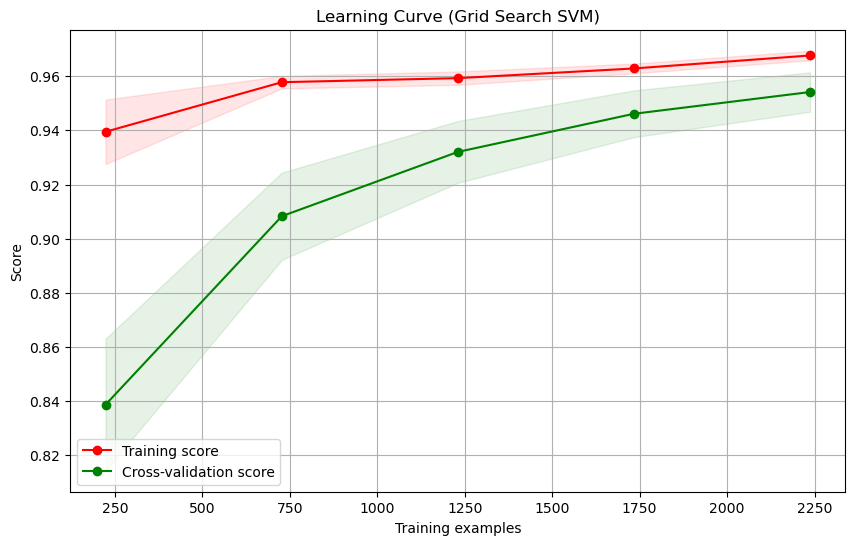

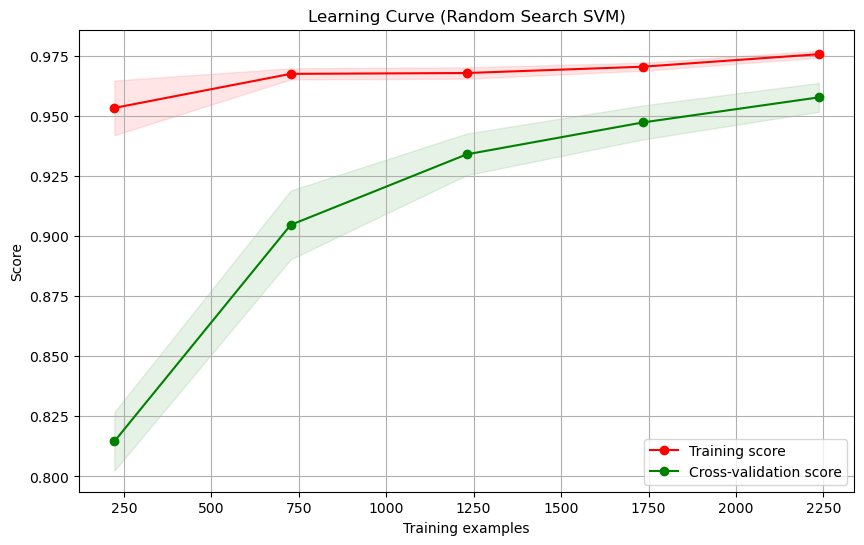

In [6]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curve for the best model from Grid Search
plot_learning_curve(best_svm_grid, "Learning Curve (Grid Search SVM)", X_train_scaled, y_train, cv=10)

# Plot learning curve for the best model from Random Search
plot_learning_curve(best_svm_random, "Learning Curve (Random Search SVM)", X_train_scaled, y_train, cv=10)

plt.show()